# Python: Conditional Average Treatment Effects (CATEs) for PLR models

In this simple example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate conditional average treatment effects with B-splines for one or two-dimensional effects in the [DoubleMLPLR](https://docs.doubleml.org/stable/guide/models.html#partially-linear-regression-model-plr) model.

## Data

We define a data generating process to create synthetic data to compare the estimates to the true effect. The data generating process is based on the Monte Carlo simulation from [Oprescu et al. (2019)](http://proceedings.mlr.press/v97/oprescu19a.html) and this [notebook](https://github.com/py-why/EconML/blob/main/notebooks/Causal%20Forest%20and%20Orthogonal%20Random%20Forest%20Examples.ipynb) from [EconML](https://github.com/py-why/EconML).

In [16]:
import numpy as np
import pandas as pd
import doubleml as dml

The data is generated as

$$
\begin{aligned}
Y_i & = g(X_i)T_i + \langle W_i,\gamma_0\rangle + \epsilon_i \\
T_i & = \langle W_i,\beta_0\rangle +\eta_i,
\end{aligned}
$$

where $W_i\sim\mathcal{N}(0,I_{d_w})$, $X_i\sim\mathcal{U}[0,1]^{d_x}$ and $\epsilon_i,\eta_i\sim\mathcal{U}[-1,1]$.
The coefficient vectors $\gamma_0$ and $\beta_0$ both have small random support which values are drawn independently from $\mathcal{U}[0,1]$.
Further, $g(x)$ defines the conditional treatment effect, which is defined differently depending on the dimension of $x$.

If $x$ is univariate the conditional treatment effect takes the following form

$$ g(x) = \exp(2x) + 3\sin(4x),$$

whereas for a two-dimensional variable $x=(x_1,x_2)$ the conditional treatment effect is defined as

$$ g(x) = \exp(2x_1) + 3\sin(4x_2).$$

In [17]:
def treatment_effect_1d(x):
    te = np.exp(2 * x) + 3 * np.sin(4 * x)
    return te

def treatment_effect_2d(x):
    te = np.exp(2 * x[0]) + 3 * np.sin(4 * x[1])
    return te

def create_synthetic_data(n_samples=200, n_w=30, support_size=5, n_x=1):
    # Outcome support
    # With the next two lines we are effectively choosing the matrix gamma in the example
    support_y = np.random.choice(np.arange(n_w), size=support_size, replace=False)
    coefs_y = np.random.uniform(0, 1, size=support_size)
    # Define the function to generate the noise
    epsilon_sample = lambda n: np.random.uniform(-1, 1, size=n_samples)
    # Treatment support
    # Assuming the matrices gamma and beta have the same non-zero components
    support_t = support_y
    coefs_t = np.random.uniform(0, 1, size=support_size)
    # Define the function to generate the noise
    eta_sample = lambda n: np.random.uniform(-1, 1, size=n_samples)

    # Generate controls, covariates, treatments and outcomes
    w = np.random.normal(0, 1, size=(n_samples, n_w))
    x = np.random.uniform(0, 1, size=(n_samples, n_x))
    # Heterogeneous treatment effects
    if n_x == 1:
        te = np.array([treatment_effect_1d(x_i) for x_i in x]).reshape(-1)
    elif n_x == 2:
        te = np.array([treatment_effect_2d(x_i) for x_i in x]).reshape(-1)
    # Define treatment
    t = np.dot(w[:, support_t], coefs_t) + eta_sample(n_samples)
    # Define the outcome
    y = te * t + np.dot(w[:, support_y], coefs_y) + epsilon_sample(n_samples)

    # Now we build the dataset
    y_df = pd.DataFrame({'y': y})
    if n_x == 1:
        x_df = pd.DataFrame({'x': x.reshape(-1)})
    elif n_x == 2:
        x_df = pd.DataFrame({'x_0': x[:,0],
                             'x_1': x[:,1]})
    t_df = pd.DataFrame({'t': t})
    w_df = pd.DataFrame(data=w, index=np.arange(w.shape[0]), columns=[f'w_{i}' for i in range(w.shape[1])])

    data = pd.concat([y_df, x_df, t_df, w_df], axis=1)

    covariates = list(w_df.columns.values) + list(x_df.columns.values)
    return data, covariates, te

## One-dimensional Example

We start with $X$ being one-dimensional and create our training data.

In [18]:
# DGP constants
np.random.seed(42)
n_samples = 2000
n_w = 10
support_size = 5
n_x = 1

# Create data
data, covariates, true_effect = create_synthetic_data(n_samples=n_samples, n_w=n_w, support_size=support_size, n_x=n_x)
data_dml_base = dml.DoubleMLData(data,
                                 y_col='y',
                                 d_cols='t',
                                 x_cols=covariates)

Next, define the learners for the nuisance functions and fit the [PLR Model](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLPLR.html). Remark that the learners are not optimal for the linear form of this example.

In [19]:
# First stage estimation
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
ml_l = RandomForestRegressor(n_estimators=500)
ml_m = RandomForestRegressor(n_estimators=500)

np.random.seed(42)

dml_plr = dml.DoubleMLPLR(data_dml_base,
                          ml_l=ml_l,
                          ml_m=ml_m,
                          n_folds=5)
print("Training PLR Model")
dml_plr.fit()

print(dml_plr.summary)

Training PLR Model
       coef   std err          t  P>|t|     2.5 %    97.5 %
t  4.553023  0.063289  71.940332    0.0  4.428979  4.677067


To estimate the CATE, we rely on the best-linear-predictor of the linear score as in [Semenova et al. (2021)](https://doi.org/10.1093/ectj/utaa027) To approximate the target function $\theta_0(x)$ with a linear form, we have to define a data frame of basis functions. Here, we rely on [patsy](https://patsy.readthedocs.io/en/latest/) to construct a suitable basis of [B-splines](https://en.wikipedia.org/wiki/B-spline).

In [20]:
import patsy
design_matrix = patsy.dmatrix("bs(x, df=5, degree=2)", {"x":data["x"]})
spline_basis = pd.DataFrame(design_matrix)

To estimate the parameters to calculate the CATE estimate call the ``cate()`` method and supply the dataframe of basis elements.

In [21]:
cate = dml_plr.cate(spline_basis)
print(cate)

================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
       coef   std err          t         P>|t|    [0.025    0.975]
0  0.240290  0.242707   0.990042  3.222737e-01 -0.235696  0.716277
1  2.945216  0.397554   7.408341  1.878229e-13  2.165551  3.724880
2  5.206118  0.254635  20.445449  1.676673e-84  4.706741  5.705496
3  5.580959  0.300861  18.549950  5.447862e-71  4.990924  6.170994
4  4.081969  0.304528  13.404251  2.717441e-39  3.484742  4.679195
5  4.866295  0.334772  14.536150  1.406205e-45  4.209756  5.522835


To obtain the confidence intervals for the CATE, we have to call the ``confint()`` method and a supply a dataframe of basis elements.
This could be the same basis as for fitting the CATE model or a new basis to e.g. evaluate the CATE model on a grid.
Here, we will evaluate the CATE on a grid from 0.1 to 0.9 to plot the final results.
Further, we construct uniform confidence intervals by setting the option ``joint`` and providing a number of bootstrap repetitions ``n_rep_boot``.

In [22]:
new_data = {"x": np.linspace(0.1, 0.9, 100)}
spline_grid = pd.DataFrame(patsy.build_design_matrices([design_matrix.design_info], new_data)[0])
df_cate = cate.confint(spline_grid, level=0.95, joint=True, n_rep_boot=2000)
print(df_cate)

       2.5 %    effect    97.5 %
0   1.862171  2.317489  2.772808
1   2.036580  2.459640  2.882700
2   2.195834  2.597915  2.999996
3   2.341208  2.732315  3.123422
4   2.474664  2.862840  3.251016
..       ...       ...       ...
95  4.375370  4.713372  5.051373
96  4.381318  4.714290  5.047262
97  4.390443  4.718232  5.046021
98  4.402022  4.725197  5.048372
99  4.415178  4.735186  5.055194

[100 rows x 3 columns]


Finally, we can plot our results and compare them with the true effect.

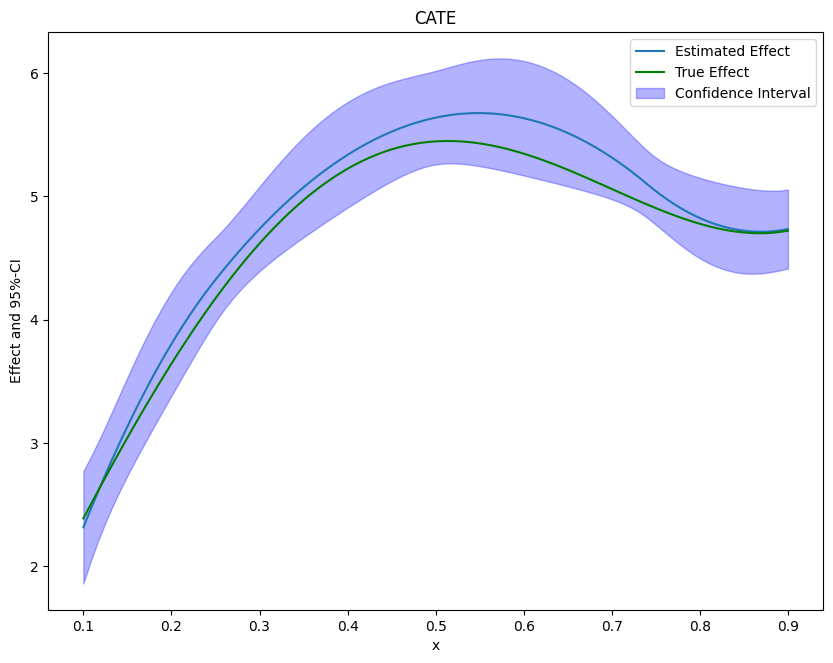

In [23]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5

df_cate['x'] = new_data['x']
df_cate['true_effect'] = treatment_effect_1d(new_data['x'])
fig, ax = plt.subplots()
ax.plot(df_cate['x'],df_cate['effect'], label='Estimated Effect')
ax.plot(df_cate['x'],df_cate['true_effect'], color="green", label='True Effect')
ax.fill_between(df_cate['x'], df_cate['2.5 %'], df_cate['97.5 %'], color='b', alpha=.3, label='Confidence Interval')

plt.legend()
plt.title('CATE')
plt.xlabel('x')
_ =  plt.ylabel('Effect and 95%-CI')

## Two-Dimensional Example

It is also possible to estimate multi-dimensional conditional effects. We will use the same data-generating process as above, but let $X$ be two-dimensional.

In [24]:
# DGP constants
np.random.seed(42)
n_samples = 5000
n_w = 10
support_size = 5
n_x = 2

In [25]:
# Create data
data, covariates, true_effect = create_synthetic_data(n_samples=n_samples, n_w=n_w, support_size=support_size, n_x=n_x)
data_dml_base = dml.DoubleMLData(data,
                                 y_col='y',
                                 d_cols='t',
                                 x_cols=covariates)

As univariate example estimate the [PLR Model](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLPLR.html).

In [26]:
# First stage estimation
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
ml_l = RandomForestRegressor(n_estimators=500)
ml_m = RandomForestRegressor(n_estimators=500)

np.random.seed(42)

dml_plr = dml.DoubleMLPLR(data_dml_base,
                          ml_l=ml_l,
                          ml_m=ml_m,
                          n_folds=5)
print("Training PLR Model")
dml_plr.fit()

print(dml_plr.summary)

Training PLR Model
       coef   std err          t  P>|t|     2.5 %    97.5 %
t  4.414185  0.064456  68.483173    0.0  4.287853  4.540518


As above, we will rely on the [patsy](https://patsy.readthedocs.io/en/latest/) package to construct the basis elements.
In the two-dimensional case, we will construct a tensor product of B-splines (for more information see [here](https://patsy.readthedocs.io/en/latest/spline-regression.html#tensor-product-smooths)).

In [27]:
design_matrix = patsy.dmatrix("te(bs(x_0, df=7, degree=3), bs(x_1, df=7, degree=3))", {"x_0": data["x_0"], "x_1": data["x_1"]})
spline_basis = pd.DataFrame(design_matrix)

cate = dml_plr.cate(spline_basis)
print(cate)

================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
         coef   std err          t         P>|t|     [0.025     0.975]
0    2.320208  0.199444  11.633362  7.011866e-31   1.929209   2.711208
1   -1.216182  1.608837  -0.755939  4.497219e-01  -4.370215   1.937851
2    2.844547  1.614863   1.761479  7.821910e-02  -0.321300   6.010395
3    2.561344  1.433843   1.786349  7.410398e-02  -0.249624   5.372311
4    2.202913  1.434738   1.535411  1.247468e-01  -0.609810   5.015635
5   -4.263818  1.795848  -2.374264  1.762190e-02  -7.784476  -0.743159
6   -3.139088  1.899368  -1.652702  9.845503e-02  -6.862691   0.584515
7   -6.806855  2.010192  -3.386172  7.142680e-04 -10.747722  -2.865988
8   -0.684564  1.755259  -0.390007  6.965479e-01  -4.125650   2.756522
9    2.520622  1.767260   1.426288  1.538482e-01  -0.943990   5.985234
10   2.056341  1.484721   1.385001  1.661146e-01  -0.854372   4.967053
11   0.442008  1.578402   0.280035  7.79

Finally, we create a new grid to evaluate and plot the effects.

In [28]:
grid_size = 100
x_0 = np.linspace(0.1, 0.9, grid_size)
x_1 = np.linspace(0.1, 0.9, grid_size)
x_0, x_1 = np.meshgrid(x_0, x_1)

new_data = {"x_0": x_0.ravel(), "x_1": x_1.ravel()}

In [29]:
spline_grid = pd.DataFrame(patsy.build_design_matrices([design_matrix.design_info], new_data)[0])
df_cate = cate.confint(spline_grid, joint=True, n_rep_boot=2000)
print(df_cate)

         2.5 %    effect    97.5 %
0     0.703531  2.412699  4.121868
1     0.767076  2.424001  4.080926
2     0.842120  2.435681  4.029242
3     0.924190  2.447700  3.971209
4     1.008680  2.460016  3.911353
...        ...       ...       ...
9995  3.281468  4.714441  6.147415
9996  3.337402  4.821486  6.305569
9997  3.410294  4.934423  6.458553
9998  3.505231  5.053786  6.602341
9999  3.625536  5.180103  6.734671

[10000 rows x 3 columns]


In [30]:
import plotly.graph_objects as go

true_effect = np.array([treatment_effect_2d(x_i) for x_i in zip(x_0.ravel(), x_1.ravel())]).reshape(x_0.shape)
effect = np.asarray(df_cate['effect']).reshape(x_0.shape)
lower_bound = np.asarray(df_cate['2.5 %']).reshape(x_0.shape)
upper_bound = np.asarray(df_cate['97.5 %']).reshape(x_0.shape)

fig = go.Figure(data=[
    go.Surface(x=x_0,
               y=x_1,
               z=true_effect),
    go.Surface(x=x_0,
               y=x_1,
               z=upper_bound, showscale=False, opacity=0.4,colorscale='purp'),
    go.Surface(x=x_0,
               y=x_1,
               z=lower_bound, showscale=False, opacity=0.4,colorscale='purp'),
])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))

fig.update_layout(scene = dict(
                    xaxis_title='X_0',
                    yaxis_title='X_1',
                    zaxis_title='Effect'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()